Instructions

Get data
	Music21-corpus
		Corpus.getComposer('bach')
	Separate into voices
		Stream.elements gives you a list of different parts
	Break up into notes/rests
		Stream.flat.notesAndRests()
	Make two bigram matrices- rhythm, pitch, normalized pitch
		Rests have rhythm but pitch can just be 'Rest'
		For chords use .root()
		Normalized pitch:
			Normalize to the same key (transpose everything to one base key, say C Major/minor)
			Stream.analyze('key')
			Create interval between base key and stream key
Stream.transpose(interval)



In [4]:
duration_set = (0.125, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0)
ds_encode_dict = {x:i for i,x in enumerate(duration_set)}
ds_decode_dict = {i:x for i,x in enumerate(duration_set)}

REST = 20

def encodeDuration(x):
    return ds_encode_dict[x]

def decodeDuration(x):
    return ds_decode_dict[x]

def encodeNote(x):
    return x - REST

def decodeNote(x):
    return x + REST
    
    

In [5]:
sorted([0.5, 1.0, 2.0, 3.0, 4.0, 6.0, 0.25, 8.0, 12.0, 0.125, 0.75, 1.5])

[0.125, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0]

In [6]:
from music21 import corpus, converter,environment, midi, interval, pitch
from music21.stream import Stream
from music21.interval import GenericInterval
import numpy as np
us = environment.UserSettings()

try:
    us.create()
except:
    pass

# us['midiPath'] = '/usr/bin/timidity'


    #for i, piece in enumerate(pieces):
    #    score = converter.parse(piece)
    #    print(piece.split("/")[-1],i,[x.partName for x in score.parts])

    #print("DONE")
    #raise ValueError()





def frequenciesFromPieces(pieces, verbose=0):


    first_note_freq = [0] * 80
    first_duration_freq = [0] * len(duration_set) 
    note_transitions = np.zeros((80,80))
    duration_transitions = np.zeros((len(duration_set),len(duration_set)))



    for i, piece in enumerate(pieces):
        if(verbose): print(piece)
        score = converter.parse(piece)
        key = score.analyze('key')
        #print(rng)
        score_interval = interval.Interval(key.tonic,pitch.Pitch('C'))
        new_score = score.transpose(score_interval)
        flattened_score = new_score.flattenParts()#["Soprano"]
        #flattened_score = new_score["Alto"]
        #flattened_score.flat.notesAndRests.stream().show('text')
        prevNote = None
        prevDuration = None
        for x in flattened_score.flat.notesAndRests.stream():
            if(x.isChord):
                note_num = x.root().midi
            else:
                note_num = x.pitch.midi
            if(x.isRest):
                note_num = REST

            e_n = encodeNote(note_num)
            e_d = encodeDuration(x.duration.quarterLength)

            if(prevNote == None):
                first_note_freq[e_n] += 1
                first_duration_freq[e_d] += 1
            else:
                note_transitions[prevNote,e_n] += 1
                duration_transitions[prevDuration,e_d] += 1

            prevNote = e_n
            prevDuration = e_d
    return first_note_freq, first_duration_freq, note_transitions, duration_transitions

def writeHDF5(name,out):
    f = h5py.File(name, 'w')
    f.create_dataset('first_note_freq', data=out[0])
    f.create_dataset('first_duration_freq', data=out[1])
    f.create_dataset('note_transitions', data=out[2])
    f.create_dataset('duration_transitions', data=out[3])
    f.close()
    
def readHDF5(name):
    f = h5py.File(name, 'r')
    out = (f["first_note_freq"][:],
           f["first_duration_freq"][:],
           f["note_transitions"][:],
           f["duration_transitions"][:])
    f.close()
    return out

def selectSimplePieces(piece):
    score = converter.parse(piece)
    return set([x.partName for x in score.parts]) == set(['Soprano', 'Alto', 'Tenor', 'Bass'])
        
        #print(first_note_priors)
        #print(first_duration_priors)
        
        #print(note_transitions)
        #print(duration_transitions)
        
        #duration_set.add(x.duration.quarterLength)
        #note_set.add(note_num)
        #print(x.isChord,x.duration.quarterLength,x.name, x.pitch.diatonicNoteNum,x.isNote)
    #print(note_set)
    #print(duration_set)
    
    #sp = midi.realtime.StreamPlayer(part)
    #sp.play()
    #print(score.flat.elements)
    #print(type(score))
    #a = score.elements.encode('utf-8').strip()
    #print(score.flat.notesAndRests())
    #break
    #for e in score.parts:
        #e = e.flat.notesAndRests()
    #    sp = midi.realtime.StreamPlayer(e)
    #    sp.play()
        
        #print(unicode(e).encode('utf8'))
    #print(score.elements[2])
    #break
    #score.flat.notesAndRests()
    #print(score)
    #score.flat.show("midi")
    #if(i > 10):
    #    break

In [7]:
import h5py

allBach = corpus.getComposer('bach')
out = frequenciesFromPieces(allBach,verbose=1)
writeHDF5('all_bach.h5', out)

simpleBach = list(filter(selectSimplePieces, allBach))
out = frequenciesFromPieces(simpleBach,verbose=1)
writeHDF5('simple_bach.h5', out)

print(len(simpleBach),len(allBach))



C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv1.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv10.7.mxl


KeyboardInterrupt: 

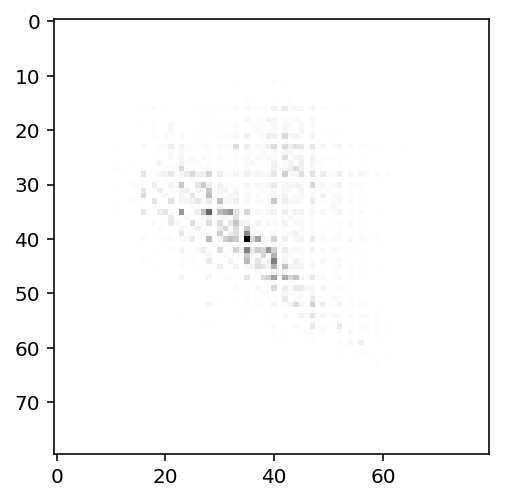

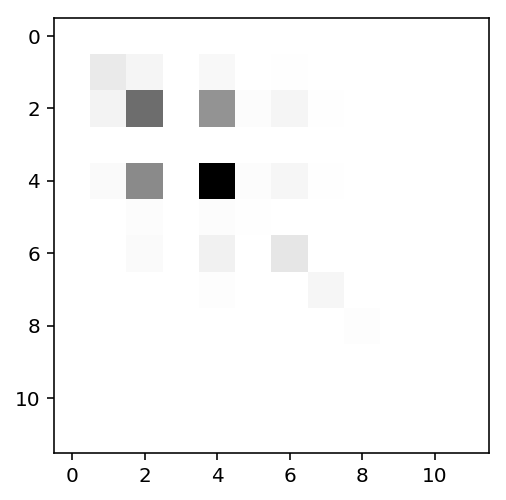

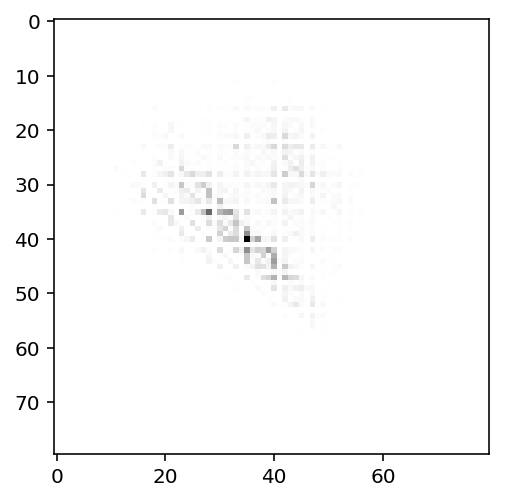

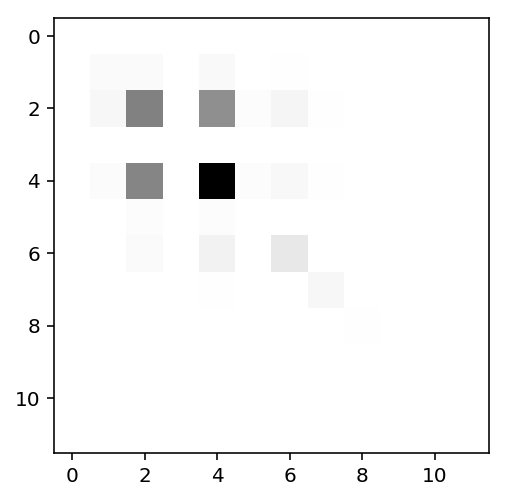

In [17]:
#f = h5py.File('all_bach.h5', 'r')
# np.unique(readHDF5('all_bach.h5')[2])
allBachMat = readHDF5('all_bach.h5')
simpleBachMat = readHDF5('simple_bach.h5')
plt.imshow(allBachMat[2], cmap='binary', interpolation='none')
plt.show()
plt.imshow(allBachMat[3], cmap='binary', interpolation='none')   
plt.show()
plt.imshow(simpleBachMat[2], cmap='binary', interpolation='none')
plt.show()
plt.imshow(simpleBachMat[3], cmap='binary', interpolation='none')   
plt.show()

In [8]:
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils

In [2]:
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        acceptance_ratio = min(1, acceptance_score(candidate,sample))
        if np.random.uniform() < acceptance_ratio:
            sample = candidate
            samples.append(sample)
    return samples[::step]

In [ ]:
def starting_state():
    """
    Start with a random permutation.
    """
    starting_ordering = list(range(0, 27))
    np.random.shuffle(starting_ordering)
    return starting_ordering

def sample_candidate(sample):
    """
    To search for new ciphers, randomly
    swap two letters in the previous cipher.
    """
    to_swap = np.random.choice(27, 2)
    new_sample = sample[:]
    new_sample[to_swap[0]], new_sample[to_swap[1]] = sample[to_swap[1]], sample[to_swap[0]]
    return new_sample

def make_acceptance_scorer(rhythm_mat, pitch_mat):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher devided by the probability of
    obseving the message translated by the current
    cipher.
    """
    def scorer(candidate, sample):
        nonlocal rhythm_mat
        nonlocal pitch_mat
        candidate_log_likeihood = 0
        sample_log_likeihood = 0
        for i in range(len(decode_string) - 1):
            first_char = ord(decode_string[i].upper()) - 65 if decode_string[i].isalpha() else 26
            second_char = ord(decode_string[i+1].upper()) - 65 if decode_string[i+1].isalpha() else 26
            
            c_first, c_second = candidate[first_char], candidate[second_char]
            candidate_log_likeihood += np.log(transition_matrix[c_first][c_second])

            s_first, s_second = sample[first_char], sample[second_char]
            sample_log_likeihood += np.log(transition_matrix[s_first][s_second])
        return np.exp(candidate_log_likeihood - sample_log_likeihood)
    return scorer

scorer = make_acceptance_scorer(the_secret_message, bigram_freq_matrix)

In [ ]:
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 10000)

In [ ]:
for sample in samples[:5]:
    print(decode(the_secret_message, sample), '\n')

In [ ]:
combined = [" ".join([str(x) for x in s]) for s in samples]
best_combined = max(set(combined),key=combined.count)
your_best_cipher = [int(x) for x in best_combined.split()]
decode(the_secret_message,your_best_cipher).upper()